In [1]:
%config IPCompleter.use_jedi = False
%load_ext autoreload

%autoreload 2

In [2]:
import sys
from pathlib import Path

In [3]:
# enable relative imports from within this notebook
cwd = Path.cwd()
root = cwd / 'src'
sys.path.insert(0, str(root))

# Moving ACLED data into Elasticsearch


In [4]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
from misc import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Ingest ACLED data for the African continent


In [5]:
rel_fpath = 'data/acled_master_africa.feather'
acled = gpd.read_feather(rel_fpath)
assert acled.crs == LATLON  # check the Coordinate Reference System (lat/lon, WGS84)
acled['event_date'] = pd.to_datetime(acled.event_date)

- Quick look at the time series:

(0.0, 4488.05)

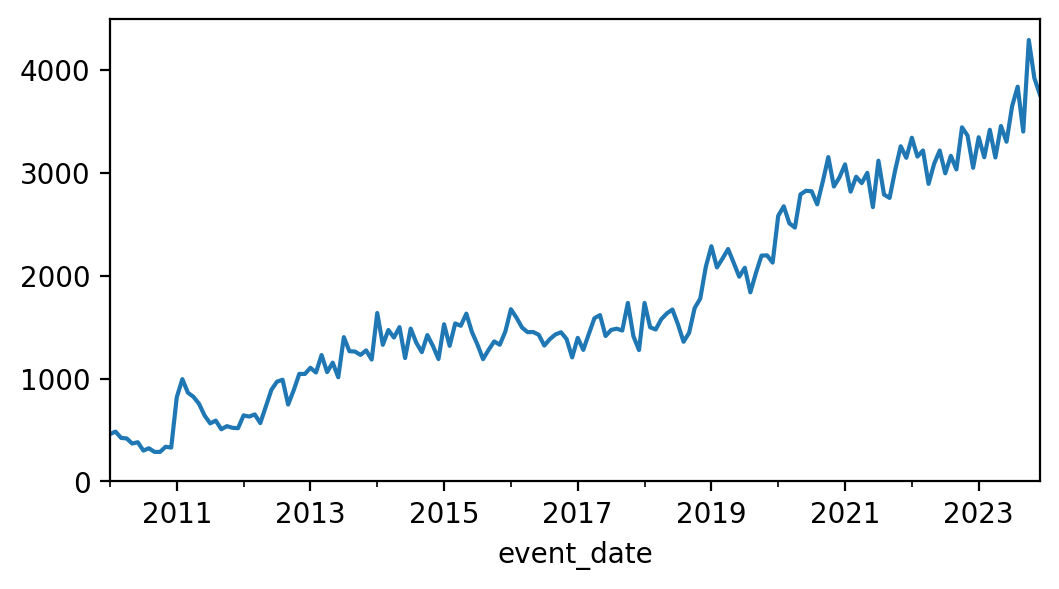

In [6]:
by_month = acled.set_index('event_date').resample('1ME')
event_counts = by_month.event_id_cnty.count()
event_counts.plot(figsize=(6, 3))
plt.ylim(0, )

- As an example, let's focus on ACLED records for the DRC in the years 2022, 2023, and 2024:

In [7]:
ISO_CODE = 'COD' # official ISO3 code of the Dem. Rep. of Congo (DRC)
YEARS = (2022, 2023, 2024)

acled_egs = acled[acled.event_date.dt.year.isin(YEARS)]  # example data
acled_egs = acled_egs[acled_egs.iso3==ISO_CODE].copy()

- GeoPandas comes with plotting functions:

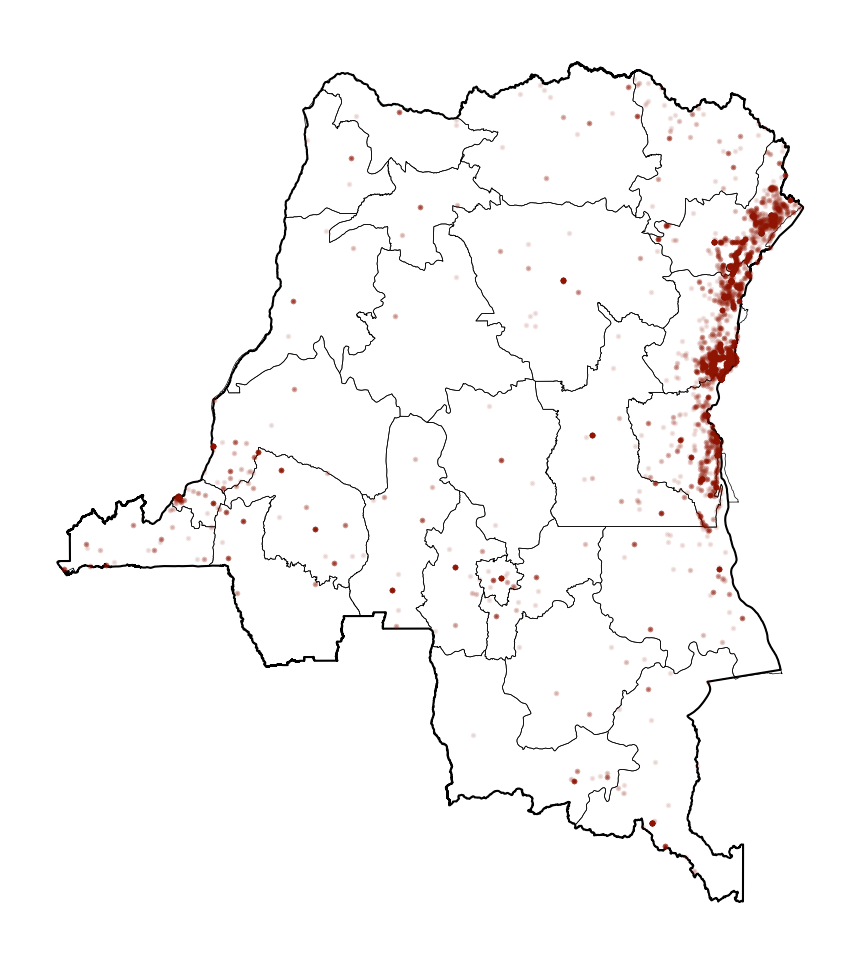

In [8]:
# Country borders of the DRC for reference
country_border = gpd.read_feather('data/drc_admin0.feather')

# Borders of sub-national provinces (admin level 1 regions) for reference
provinces = gpd.read_feather('data/drc_admin1.feather')

# Note: By default, all geo-data ingested thus far uses spatial dimensions 
# expressed in degrees (lat/lon). Let's reproject the geo-data to an equal
# area projection before plotting. (This can done using the `to_crs` method).
acled_egs.to_crs(ALBERS_AFRICA).plot(markersize=1, alpha=0.1, color=RED, zorder=10, figsize=(6, 6))
ax = plt.gca()
country_border.to_crs(ALBERS_AFRICA).plot(color='None', linewidth=0.75, ax=ax)
provinces.to_crs(ALBERS_AFRICA).plot(color='None', linewidth=0.25, ax=ax)
format_geo_axis()

### Converting ACLED records into Elastisearch "documents"


In [10]:
from src.elastic_acled import ACLEDIndexer

In [11]:
pwd = "<your_password>"
# > copy this from the console in which you have started the Elasticsearch docker container

- Test data (DRC for three years only)

- All ACLED data (Africa from 2010 onwards):

In [ ]:
helper = ACLEDIndexer(
    index_name='acled_africa', 
    password=pwd, 
    reset_index=True  # delete existing index and re-create it from scratch
)
helper.index_events(acled)